In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import copy import copy 
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

SyntaxError: invalid syntax (<ipython-input-2-a526da86329a>, line 6)

In [3]:
from src.dataloader import *
from src.models import *
from src.trainer import *
from src.utils import *

In [4]:
from torchsummary import summary

## Data

In [5]:
DATADRIVE = '/datadrive_ssd/'

In [6]:
ds_train = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2018-06'),
    val_days=5,
    split='train',
    pure_sr_ratio=8, 
    tp_log=0.01
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [7]:
ds_valid = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2018-01', '2018-12'),
    val_days=5,
    split='valid',
    mins=ds_train.mins,
    maxs=ds_train.maxs,
    pure_sr_ratio=8,
    tp_log= 0.01
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [8]:
sampler_train = torch.utils.data.WeightedRandomSampler(ds_train.compute_weights(), len(ds_train))
sampler_valid = torch.utils.data.WeightedRandomSampler(ds_valid.compute_weights(), len(ds_valid))

In [9]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=16, sampler=sampler_train)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=16, sampler=sampler_valid)

In [10]:
len(ds_train), len(dl_train)

(9972, 624)

In [11]:
# X, y = next(iter(dl_train))
# fig, axs = plt.subplots(32, 2, figsize=(6, 96))
# for x, ax in zip([val for pair in zip(X.numpy(), y.numpy()) for val in pair], axs.flat):
#     im = ax.imshow(x[0], cmap='gist_ncar_r', vmin=0, vmax=1)

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(im, cax=cbar_ax)

# Ilan first gan

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.utils import tqdm, device
from src.layers import *

In [278]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes=256, planes=256, stride=1, nonlin = 'relu'):
        super(BasicBlock, self).__init__()
        self.nonlin = nonlin
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
        self.nonlin = nonlin
        self.initialise_weights()

    def forward(self, x):
        if self.nonlin == 'leaky_relu':
            out = F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.02)
            out = self.bn2(self.conv2(out))
            out = out + self.shortcut(x)
            out = F.leaky_relu(out, negative_slope=0.02)
            return out
        elif self.nonlin == 'relu':
            out = F.relu(self.bn1(self.conv1(x)))
            out = self.bn2(self.conv2(out))
            out = out + self.shortcut(x)
            out = F.relu(out)
            return out
        else: raise NotImplementedError
            
    def initialise_weights(self):
        for m in self.modules():
            if type(m)== nn.Conv2d or type(m)==nn.Linear:
                torch.nn.init.kaiming_normal_(m.weight, nonlinearity=self.nonlin)
            
class gen1(nn.Module):
    def __init__(self, block, device):
        super(gen1, self).__init__()
        self.conv1 = nn.Conv2d(1,248, kernel_size=3, padding=1)
        self.b1 = block(in_planes=256, planes=256, stride=1,  nonlin = 'relu')
        self.b2 = block(in_planes=256, planes=256, stride=1, nonlin = 'relu')
#         self.b3 = block(in_planes=256, planes=256, stride=1, nonlin = 'relu')
#         self.b4 = block(in_planes=256, planes=256, stride=1, nonlin = 'leaky_relu')
        self.b5 = block(in_planes=256, planes=128, stride=1, nonlin = 'leaky_relu')
        self.b6 = block(in_planes=128, planes=64, stride=1, nonlin = 'leaky_relu')
        self.b7 = block(in_planes=64, planes=32, stride=1, nonlin = 'leaky_relu')
        self.final = nn.Conv2d(32,1, kernel_size=3, padding=1)
        self.upscale = torch.nn.UpsamplingBilinear2d(scale_factor=2)
        
    def forward(self, x, noise):
        x = F.relu(self.conv1(x))
        x = torch.cat((x,noise), axis=1)
        x = self.b1(x)
        x = self.b2(x)
#         x = self.b3(x)
#         x = self.b4(x)
        x = self.b5(self.upscale(x))
        x = self.b6(self.upscale(x))
        x = self.b7(self.upscale(x))
        x = torch.sigmoid(self.final(x))
        return x
        
    

class disc1(nn.Module):
    def __init__(self, block, nonlin = 'leaky_relu'):
        super(disc1, self).__init__()
        hr_block = []
        lr_block = []
        inplanes = 1
        for planes in [64, 128, 256]:
            hr_block.append(block(in_planes = inplanes, planes=planes, stride=2, nonlin = nonlin))
            lr_block.append(block(in_planes = inplanes, planes=planes, stride=1, nonlin = nonlin))
            inplanes=planes
        self.hr_block1 = nn.Sequential(*hr_block)
        self.lr_block1 = nn.Sequential(*lr_block)
        self.hr_block2 = nn.Sequential(block(in_planes=256, planes=256, stride=1, nonlin = nonlin))#, block(in_planes=256, planes=256, stride=1, nonlin = nonlin))
        self.lr_block2 = nn.Sequential(block(in_planes=512, planes=256, stride=1, nonlin = nonlin))#,block(in_planes=256, planes=256, stride=1, nonlin = nonlin))
        self.dense1 = nn.Linear(512, 256)
        self.dense2 = nn.Linear(256, 1)
        

    def forward(self, X, y):
        hr = self.hr_block1(y)
        lr = self.lr_block1(X)
#         print(lr.shape)
#         print(hr.shape)
        lr = torch.cat((lr,hr), axis=1)
        hr = self.hr_block2(hr)
        lr = self.lr_block2(lr)
        hr = nn.AvgPool2d(16)(hr)
        lr = nn.AvgPool2d(16)(lr)
        out = torch.cat((torch.squeeze(hr), torch.squeeze(lr)), axis=1)
        out = F.leaky_relu(self.dense1(out), negative_slope=0.02)
        out = self.dense2(out)
        return out
        

In [279]:
def get_gradient(crit, X, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(X, mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        # Note: You need to take the gradient of outputs with respect to inputs.
        # This documentation may be useful, but it should not be necessary:
        # https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad
        #### START CODE HERE ####
        inputs=mixed_images,
        outputs=mixed_scores,
        #### END CODE HERE ####
        # These other parameters have to do with the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient


def gradient_penalty(gradient):
    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim=1)
    penalty = torch.mean((gradient_norm -1)**2)
    return penalty

def wasserstein_loss(y_true, y_pred):
    return torch.mean(y_true * y_pred)

def loss_D(lr,real,noise,G,D,lam):
    fake = G(lr,noise)
    D_real = D(lr,real)
    D_fake = D(lr,fake)
    D_real_loss = wasserstein_loss(torch.ones_like(D_real), D_real)
    D_fake_loss = wasserstein_loss(-torch.ones_like(D_fake), D_fake)
    l = D_real_loss + D_fake_loss
    epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
    gradient = get_gradient(D, lr, real, fake.detach(), epsilon)
    grad_penalty = gradient_penalty(gradient)
    l+= lam*grad_penalty
    return l
    
def loss_G(lr,noise, G, D):
    fake = G(lr,noise)
    D_fake = D(lr, fake)
    return wasserstein_loss(torch.ones_like(D_fake), D_fake)



In [280]:
def plot_sample(X, y, gen, k=1):
    with torch.no_grad():
        noise = torch.randn(X.shape[0], 8, X.shape[2], X.shape[3]).to(device)
        preds = gen(X.to(device), noise).detach().cpu().numpy()
    
    for i in range(k):
        lr = X[i, 0].detach().cpu().numpy()
        hr = y[i, 0].detach().cpu().numpy()
        pred = preds[i, 0]

        mn = np.min([np.min(lr), np.min(hr), np.min(pred)])
        mx = np.max([np.max(lr), np.max(hr), np.max(pred)])

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        im = ax1.imshow(lr, vmin=mn, vmax=mx, cmap='gist_ncar_r')
        plt.colorbar(im, ax=ax1, shrink=0.7)
        im = ax2.imshow(pred, vmin=mn, vmax=mx, cmap='gist_ncar_r')
        plt.colorbar(im, ax=ax2, shrink=0.7)
        im = ax3.imshow(hr, vmin=mn, vmax=mx, cmap='gist_ncar_r')
        plt.colorbar(im, ax=ax3, shrink=0.7)
        plt.show()


In [281]:
G = gen1(BasicBlock, device).to(device)
D = disc1(BasicBlock).to(device)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 11.17 GiB total capacity; 10.86 GiB already allocated; 2.81 MiB free; 10.89 GiB reserved in total by PyTorch)

In [27]:
X, y = next(iter(dl_train))
X_sample, y_sample = X.to(device), y.to(device)

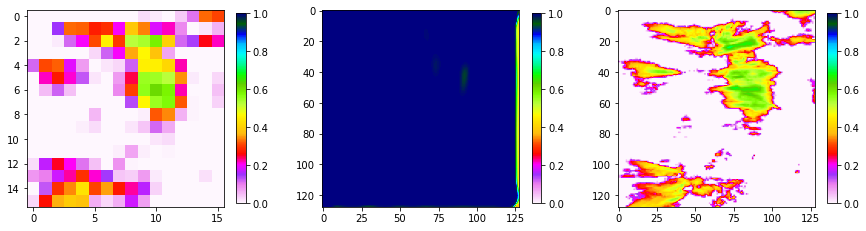

In [28]:
plot_sample(X_sample, y_sample, G)

In [276]:
D = disc1(BasicBlock).to(device)
G = gen1(BasicBlock, device).to(device)

In [277]:
rounds = 1000

train_disc = True
disc_steps = 5
gen_steps = 5

lam = 10

gen_train_loss = []
disc_train_loss = []
epoch_gen_train_loss = []
epoch_disc_train_loss = []
gen_val_loss = []
disc_val_loss = []


for m in D.modules():
    if type(m)== nn.Conv2d or type(m)==nn.Linear:
        m = torch.nn.utils.spectral_norm(m)
        print(m)
        
d_opt  = torch.optim.Adam(D.parameters(), lr=0.001)
g_opt = torch.optim.Adam(G.parameters(), lr=0.001, weight_decay=0.0001)

it = 0
steps_per_epoch = len(dl_train)/((disc_steps + gen_steps)/2)

for step in range(rounds):
    if step % steps_per_epoch == 0:
        print(f"epoch {step/steps_per_epoch}")
#         batch_gen_val_loss = []
#         batch_disc_val_loss = []
#         G.eval()
#         D.eval()
#         for idx, (lr, hr) in enumerate(dl_valid):
#             lr = lr.to(device)
#             hr = hr.to(device)
#             noise = torch.randn(lr.shape[0], 8, lr.shape[2], lr.shape[3]).to(device)
#             batch_disc_val_loss.append(loss_D(lr, hr, noise, G, D, lam).item())
#             batch_gen_val_loss.append(loss_G(lr, noise, G, D).item())
#             if idx==0:
#                 plot_sample(lr, hr, G)
#         dvl = np.mean(batch_disc_val_loss)
#         print("Disc val loss:", dvl)
#         gvl = np.mean(batch_gen_val_loss)
#         print("Gen val loss:", gvl)
#         disc_val_loss.append(dvl)
#         gen_val_loss.append(gvl)
        dtl = np.mean(epoch_disc_train_loss)
        gtl = np.mean(epoch_gen_train_loss)
        print("Gen train loss:", gtl)
        print("Disc train loss:", dtl)
        gen_train_loss.append(gtl)
        disc_train_loss.append(dtl)
        epoch_gen_train_loss = []
        epoch_disc_train_loss = []
        
        
    if train_disc:
        D.train(True)
        G.train(False)
        
        for i in range(disc_steps):
            lr, hr = next(iter(dl_train))
            lr = lr.to(device)
            hr = hr.to(device)
            d_opt.zero_grad()
            noise = torch.randn(lr.shape[0], 8, lr.shape[2], lr.shape[3]).to(device)
            loss = loss_D(lr, hr, noise, G, D, lam)
            loss.backward()
            epoch_disc_train_loss.append(loss.item())
            d_opt.step()
            it+=1
        train_disc = not train_disc
        continue
    
    elif not train_disc:
        D.train(False)
        G.train(True)
        
        for i in range(gen_steps):
            lr, hr = next(iter(dl_train))
            lr = lr.to(device)
            hr = hr.to(device)
            g_opt.zero_grad()
            noise = torch.randn(lr.shape[0], 8, lr.shape[2], lr.shape[3]).to(device)
            loss = loss_G(lr, noise, G, D)
            loss.backward()
            epoch_gen_train_loss.append(loss.item())
            g_opt.step()
            it+=1
            
#         print(epoch_gen_train_loss)
        train_disc = not train_disc
        continue
        
    

Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(1, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Linear(in_features=256, out_features=128, bias=True)
Linear(in_features=128, out_features=1, bias=True)
epoch 0.0
Gen tr

TypeError: loss_D() takes 4 positional arguments but 6 were given

In [104]:
# summary(D)

In [204]:
# summary(G)

In [160]:
def reconstruction_loss(lr,real,noise,g):
    fake = g(lr,noise)
    l = F.mse_loss(real,fake)
    return l

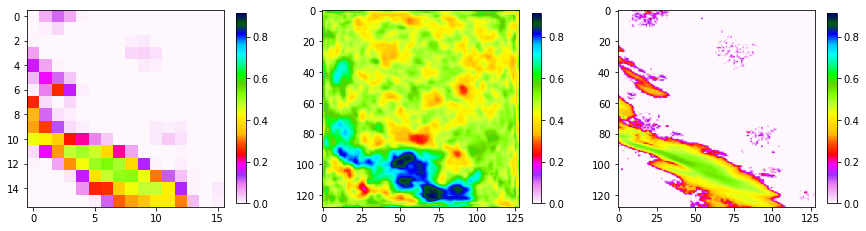

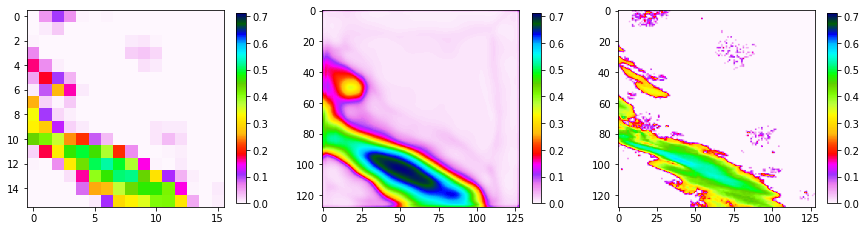

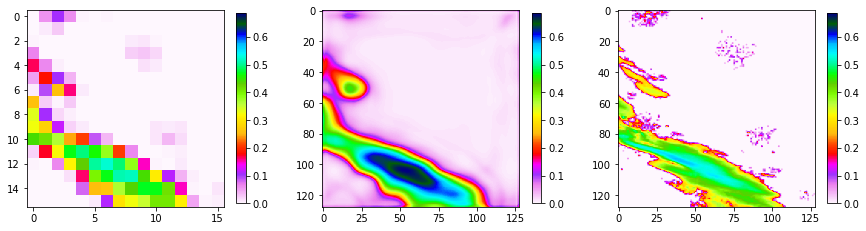

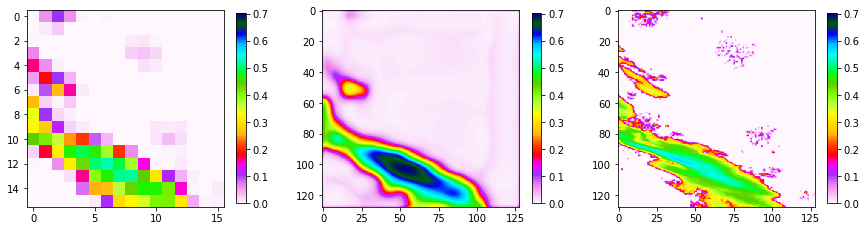

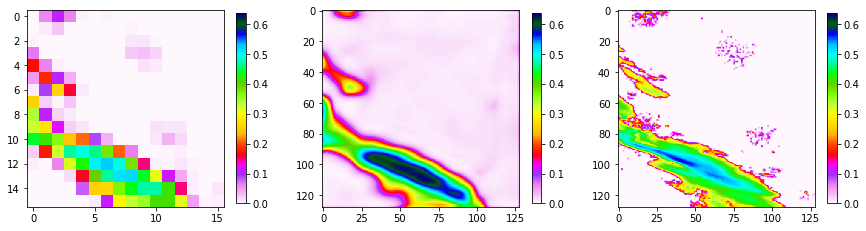

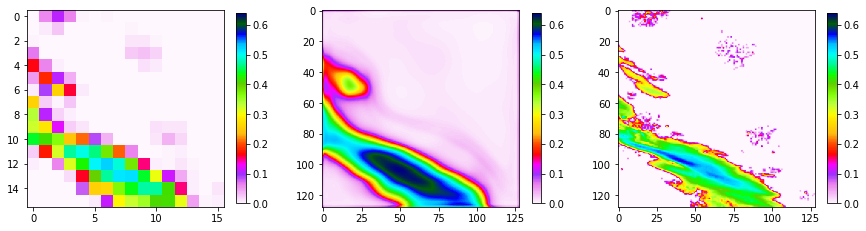

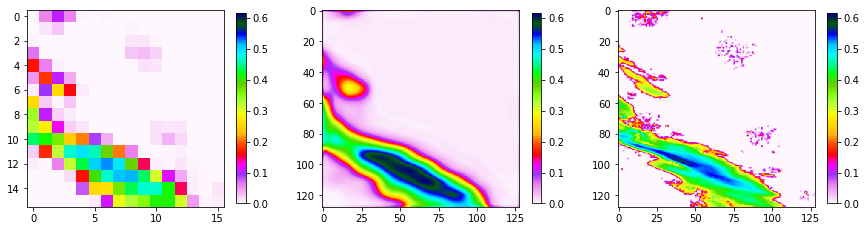

[0.006188337984218752]


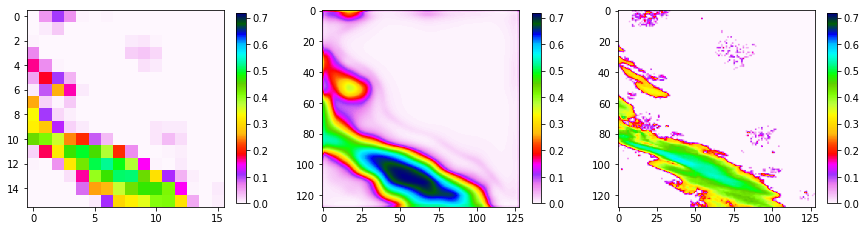

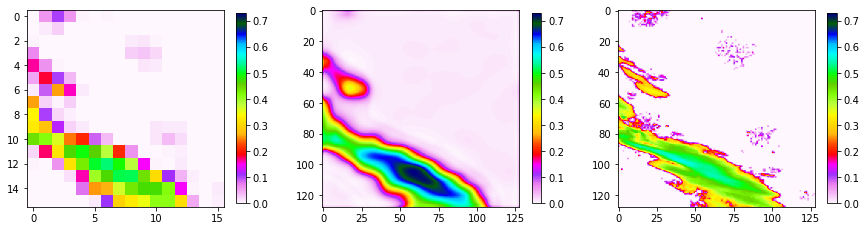

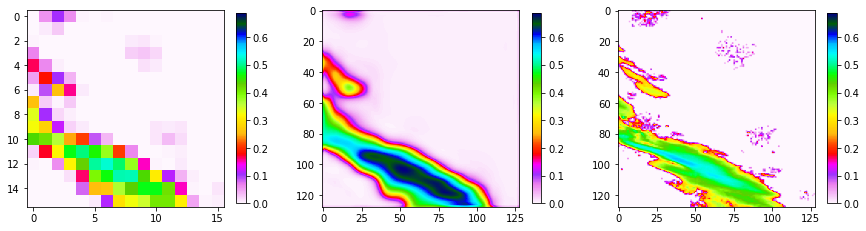

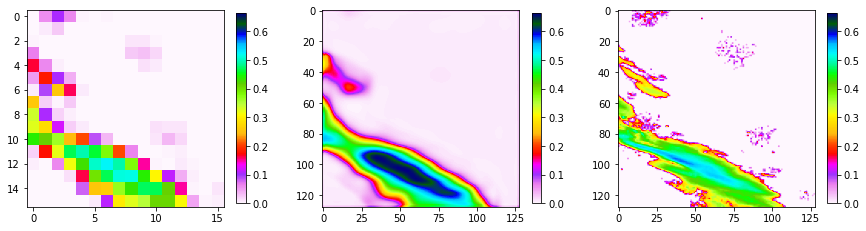

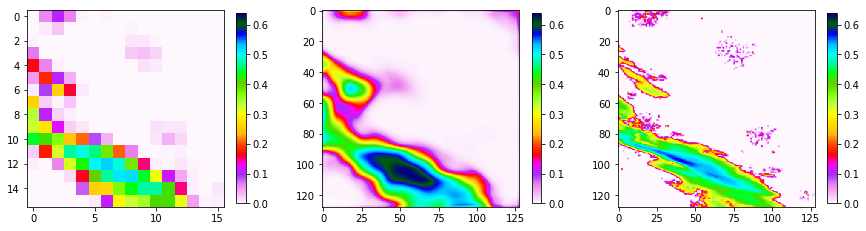

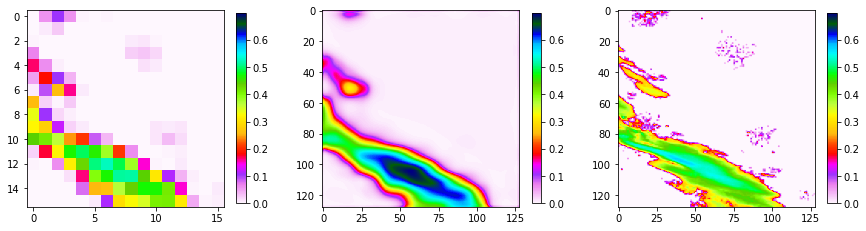

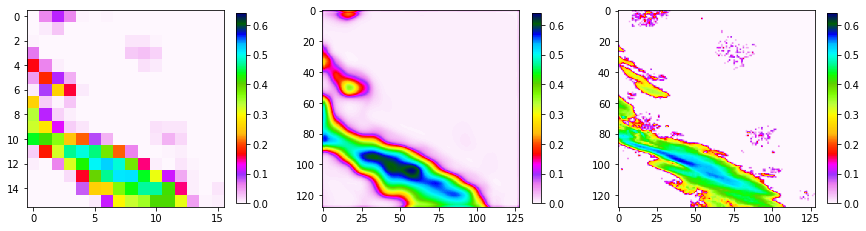

[0.006188337984218752, 0.0040674016714687105]


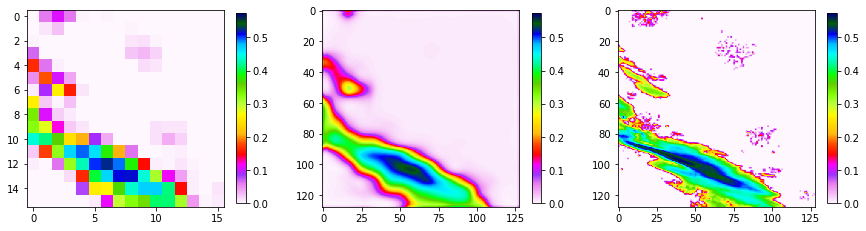

KeyboardInterrupt: 

In [189]:
G = gen1(BasicBlock, device).to(device)
g = copy.deepcopy(G)
opt = torch.optim.Adam(G.parameters(), lr=0.001, weight_decay=0.0001)

train_loss = []

for epoch in range(5):
    epoch_loss = []
    G.train()
    for batch_idx, (lr,hr) in enumerate(dl_train):
        lr = lr.to(device)
        hr = hr.to(device)
        noise = torch.randn(lr.shape[0], 8, lr.shape[2], lr.shape[3]).to(device)
        fake = G(lr, noise)
        opt.zero_grad()
        loss = F.mse_loss(fake, hr)
        loss.backward()
        epoch_loss.append(loss.item())
        opt.step()
        
        if batch_idx%100 ==0:
            plot_sample(X_sample, y_sample, G)
    train_loss.append(np.mean(epoch_loss))
    print(train_loss)

In [196]:

X_sample[0].shape

torch.Size([1, 16, 16])

In [122]:
gen_train_loss

[nan, 0.49833647161722183]

# Most basic GAN

In [29]:
# Goal - to general realistic looking ranfall patterns (unconditional)


# Generator: noise (single channel size of future conditional) -> fake image

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes=256, planes=256, stride=1, nonlin = 'relu'):
        super(BasicBlock, self).__init__()
        self.nonlin = nonlin
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
        self.nonlin = nonlin
        self.initialise_weights()

    def forward(self, x):
        if self.nonlin == 'leaky_relu':
            out = F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.02)
            out = self.bn2(self.conv2(out))
            out = out + self.shortcut(x)
            out = F.leaky_relu(out, negative_slope=0.02)
            return out
        elif self.nonlin == 'relu':
            out = F.relu(self.bn1(self.conv1(x)))
            out = self.bn2(self.conv2(out))
            out = out + self.shortcut(x)
            out = F.relu(out)
            return out
        else: raise NotImplementedError
            
    def initialise_weights(self):
        for m in self.modules():
            if type(m)== nn.Conv2d or type(m)==nn.Linear:
                torch.nn.init.kaiming_normal_(m.weight, nonlinearity=self.nonlin)
            
class gen1(nn.Module):
    def __init__(self, block, device):
        super(gen1, self).__init__()
        self.b1 = block(in_planes=1, planes=64, stride=1,  nonlin = 'leaky_relu')
#         self.b2 = block(in_planes=64, planes=64, stride=1, nonlin = 'leaky_relu')
        self.b5 = block(in_planes=64, planes=64, stride=1, nonlin = 'leaky_relu')
        self.b6 = block(in_planes=64, planes=64, stride=1, nonlin = 'leaky_relu')
        self.b7 = block(in_planes=64, planes=32, stride=1, nonlin = 'leaky_relu')
        self.final = nn.Conv2d(32,1, kernel_size=3, padding=1)
        self.upscale = torch.nn.UpsamplingBilinear2d(scale_factor=2)
        
    def forward(self, x):
        x = self.b1(x)
#         x = self.b2(x)
        x = self.b5(self.upscale(x))
        x = self.b6(self.upscale(x))
        x = self.b7(self.upscale(x))
        x = torch.sigmoid(self.final(x))
        return x
        
# Discriminator: image -> 0 or 1 (real or fake)

class disc1(nn.Module):
    def __init__(self, block, nonlin = 'leaky_relu'):
        super(disc1, self).__init__()
        hr_block = []
#         lr_block = []
        inplanes = 1
        for planes in [32, 64, 128]:
            hr_block.append(block(in_planes = inplanes, planes=planes, stride=2, nonlin = nonlin))
#             lr_block.append(block(in_planes = inplanes, planes=planes, stride=1, nonlin = nonlin))
            inplanes=planes
        self.hr_block1 = nn.Sequential(*hr_block)
#         self.lr_block1 = nn.Sequential(*lr_block)
        self.hr_block2 = nn.Sequential(block(in_planes=128, planes=128, stride=1, nonlin = nonlin))#, block(in_planes=256, planes=256, stride=1, nonlin = nonlin))
#         self.lr_block2 = nn.Sequential(block(in_planes=512, planes=256, stride=1, nonlin = nonlin))#,block(in_planes=256, planes=256, stride=1, nonlin = nonlin))
        self.dense1 = nn.Linear(128, 128)
        self.dense2 = nn.Linear(128, 1)
        

    def forward(self, y):
        hr = self.hr_block1(y)
#         lr = self.lr_block1(X)
#         lr = torch.cat((lr,hr), axis=1)
        hr = self.hr_block2(hr)
#         lr = self.lr_block2(lr)
        hr = nn.AvgPool2d(16)(hr)
        hr = torch.squeeze(hr)
#         lr = nn.AvgPool2d(16)(lr)
#         out = torch.cat((torch.squeeze(hr), torch.squeeze(lr)), axis=1)
        out = F.leaky_relu(self.dense1(hr), negative_slope=0.02)
        out = self.dense2(out)
        return torch.sigmoid(out)


def loss_D(real,noise,G,D):
    fake = G(noise)
    D_real = D(real)
    D_fake = D(fake)
    loss_func = nn.BCELoss()
    D_real_loss = loss_func(D_real, torch.ones_like(D_real))
    D_fake_loss = loss_func(D_fake, torch.zeros_like(D_fake))
    l = D_real_loss + D_fake_loss
#     epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
#     gradient = get_gradient(D, lr, real, fake.detach(), epsilon)
#     grad_penalty = gradient_penalty(gradient)
#     l+= lam*grad_penalty
    return l
    
def loss_G(noise, G, D):
    fake = G(noise)
    D_fake = D(fake)
    loss_func = nn.BCELoss()
    return loss_func(D_fake, torch.ones_like(D_fake))


Layer (type:depth-idx)                   Param #
├─BasicBlock: 1-1                        --
|    └─Conv2d: 2-1                       576
|    └─BatchNorm2d: 2-2                  128
|    └─Conv2d: 2-3                       36,864
|    └─BatchNorm2d: 2-4                  128
|    └─Sequential: 2-5                   --
|    |    └─Conv2d: 3-1                  64
|    |    └─BatchNorm2d: 3-2             128
├─BasicBlock: 1-2                        --
|    └─Conv2d: 2-6                       36,864
|    └─BatchNorm2d: 2-7                  128
|    └─Conv2d: 2-8                       36,864
|    └─BatchNorm2d: 2-9                  128
|    └─Sequential: 2-10                  --
├─BasicBlock: 1-3                        --
|    └─Conv2d: 2-11                      36,864
|    └─BatchNorm2d: 2-12                 128
|    └─Conv2d: 2-13                      36,864
|    └─BatchNorm2d: 2-14                 128
|    └─Sequential: 2-15                  --
├─BasicBlock: 1-4                        --

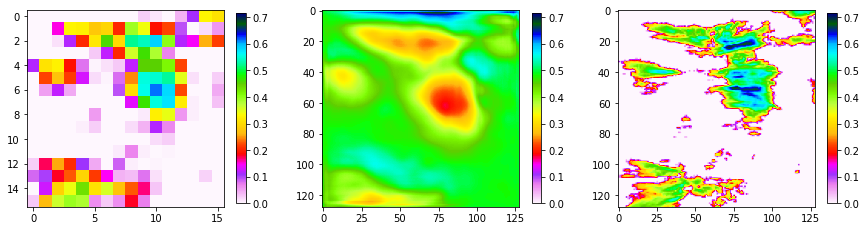

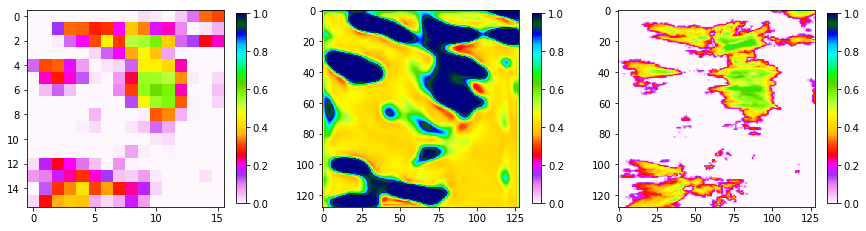

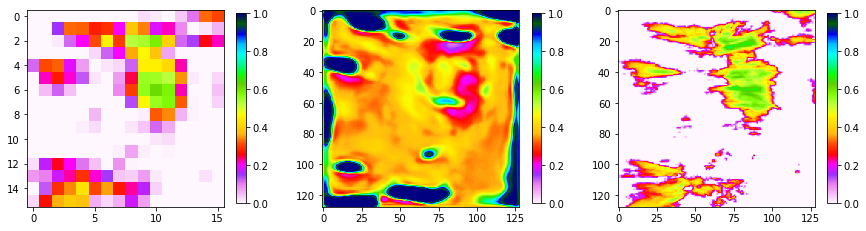

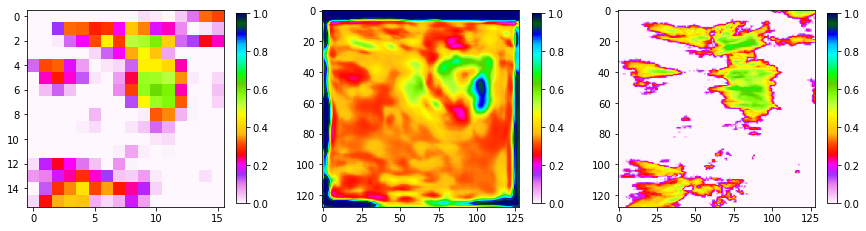

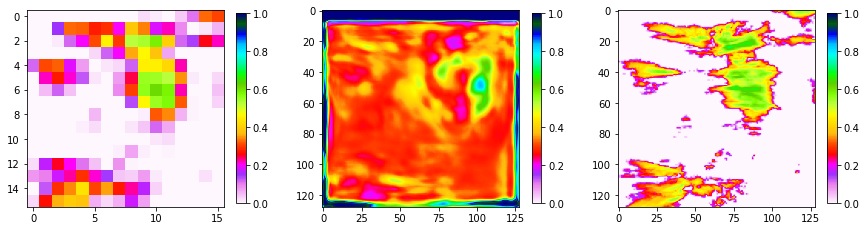

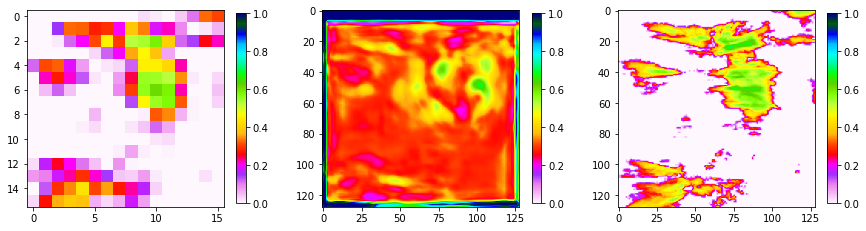

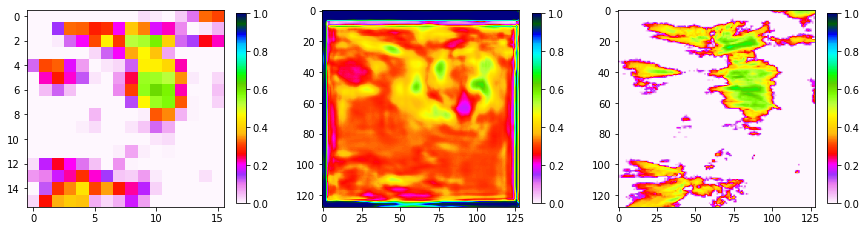

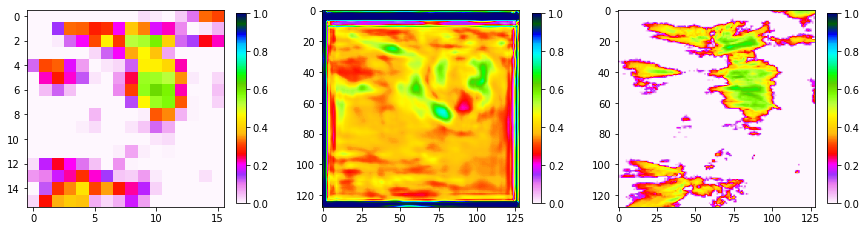

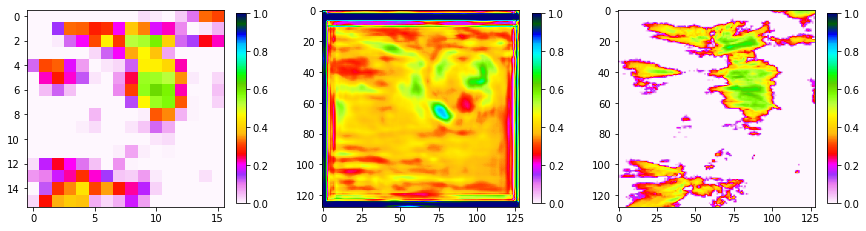

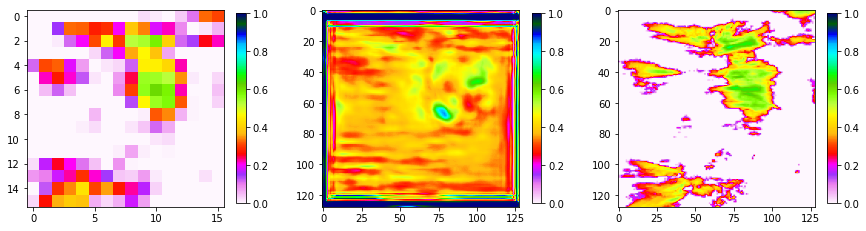

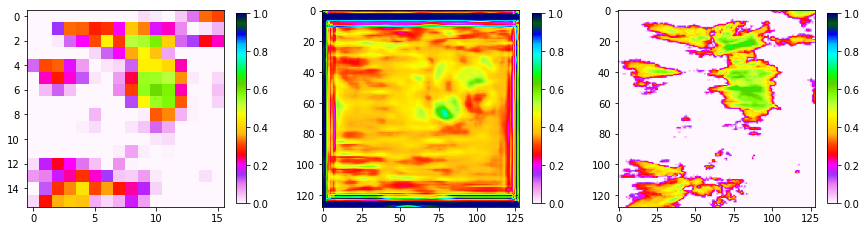

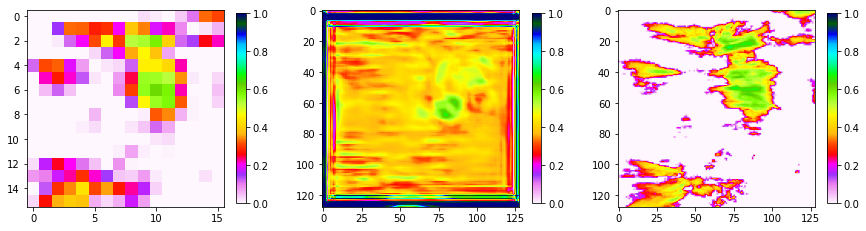

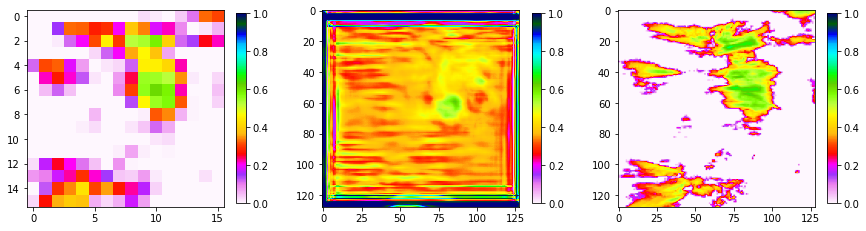

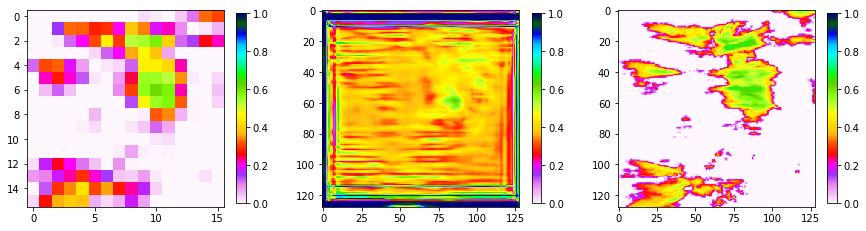

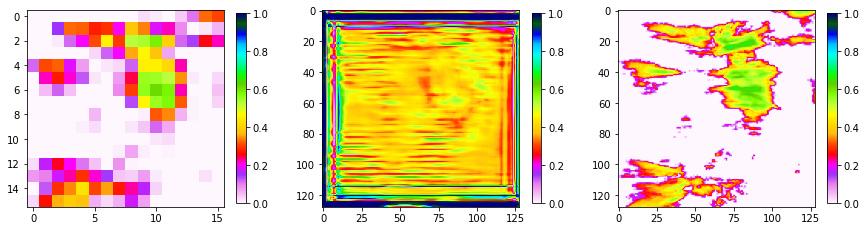

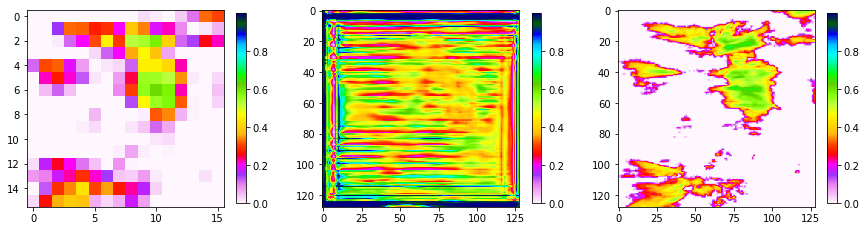

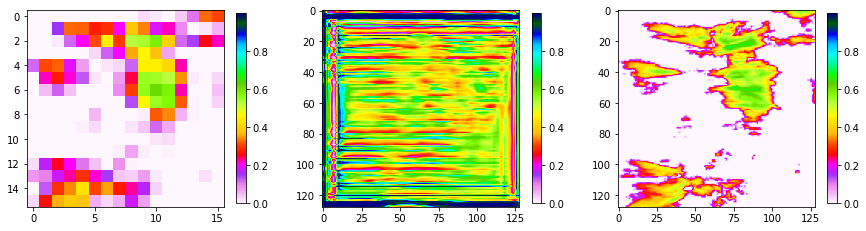

In [33]:
rounds = 5000

train_disc = True
disc_steps = 1
gen_steps = 1

lam = 10

gen_train_loss = []
disc_train_loss = []
epoch_gen_train_loss = []
epoch_disc_train_loss = []
gen_val_loss = []
disc_val_loss = []

D = disc1(BasicBlock).to(device)
G = gen1(BasicBlock, device).to(device)

summary(G)
summary(D)


# for m in D.modules():
#     if type(m)== nn.Conv2d or type(m)==nn.Linear:
#         m = torch.nn.utils.spectral_norm(m)
#         print(m)
        
d_opt  = torch.optim.Adam(D.parameters(), lr=0.0001)
g_opt = torch.optim.Adam(G.parameters(), lr=0.0001, weight_decay=0.0001)

it = 0
steps_per_epoch = len(dl_train)/(disc_steps + gen_steps)

for step in range(rounds):
    if step % steps_per_epoch == 0:
        print(f"epoch {step/steps_per_epoch}")
        dtl = np.mean(epoch_disc_train_loss)
        gtl = np.mean(epoch_gen_train_loss)
        print("Gen train loss:", gtl)
        print("Disc train loss:", dtl)
        gen_train_loss.append(gtl)
        disc_train_loss.append(dtl)
        epoch_gen_train_loss = []
        epoch_disc_train_loss = []
        plot_sample(X_sample, y_sample, G)
        
    if train_disc:
        D.train(True)
        G.train(False)
        
        for i in range(disc_steps):
            lr, hr = next(iter(dl_train))
            lr = lr.to(device)
            hr = hr.to(device)
            d_opt.zero_grad()
            noise = torch.randn(lr.shape[0], 1, lr.shape[2], lr.shape[3]).to(device)
            loss = loss_D(hr, noise, G, D)
            loss.backward()
            epoch_disc_train_loss.append(loss.item())
            d_opt.step()
            it+=1
        train_disc = not train_disc
        continue
    
    elif not train_disc:
        D.train(False)
        G.train(True)
        
        for i in range(gen_steps):
            lr, hr = next(iter(dl_train))
            lr = lr.to(device)
            hr = hr.to(device)
            g_opt.zero_grad()
            noise = torch.randn(lr.shape[0], 1, lr.shape[2], lr.shape[3]).to(device)
            loss = loss_G(noise, G, D)
            loss.backward()
            epoch_gen_train_loss.append(loss.item())
            g_opt.step()
            it+=1
            
#         print(epoch_gen_train_loss)
        train_disc = not train_disc
        continue
        
    

In [229]:
img_grid_real = torchvision.utils.make_grid(
                    data[:32], normalize=True
                )
img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )